In [12]:
import ase.io
from src.hypers import load_hypers_from_file
from src.data_preparation import get_all_species
from src.pet import PET, PETUtilityWrapper, PETMLIPWrapper
# from src.pet_old import PET, PETUtilityWrapper, PETMLIPWrapper

import torch
from src.molecule import MoleculeCPP, Molecule, batch_to_dict
from matscipy.neighbours import neighbour_list as neighbor_list

torch.set_default_dtype(torch.float32)

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def prepare_test(
    stucture_path,
    r_cut,
    n_gnn,
    n_trans,
    hypers_path="./default_hypers/default_hypers.yaml",
):
    structure = ase.io.read(stucture_path, index=0)
    hypers = load_hypers_from_file(hypers_path)

    MLIP_SETTINGS = hypers.MLIP_SETTINGS
    ARCHITECTURAL_HYPERS = hypers.ARCHITECTURAL_HYPERS
    FITTING_SCHEME = hypers.FITTING_SCHEME

    ARCHITECTURAL_HYPERS.D_OUTPUT = 1  # energy is a single scalar
    ARCHITECTURAL_HYPERS.TARGET_TYPE = "structural"  # energy is structural property
    ARCHITECTURAL_HYPERS.TARGET_AGGREGATION = (
        "sum"  # energy is a sum of atomic energies
    )
    ARCHITECTURAL_HYPERS.R_CUT = r_cut
    ARCHITECTURAL_HYPERS.N_TRANS_LAYERS = n_trans
    ARCHITECTURAL_HYPERS.N_GNN_LAYERS = n_gnn
    all_species = get_all_species([structure])

    model = PET(ARCHITECTURAL_HYPERS, 0.0, len(all_species)).to(device)
    model = PETUtilityWrapper(model, FITTING_SCHEME.GLOBAL_AUG)

    model = PETMLIPWrapper(model, MLIP_SETTINGS.USE_ENERGIES, MLIP_SETTINGS.USE_FORCES)
    return model, structure, all_species, ARCHITECTURAL_HYPERS

In [14]:
def get_graph(structure, all_species, ARCHITECTURAL_HYPERS):
    molecule = Molecule(
        structure,
        ARCHITECTURAL_HYPERS.R_CUT,
        ARCHITECTURAL_HYPERS.USE_ADDITIONAL_SCALAR_ATTRIBUTES,
        ARCHITECTURAL_HYPERS.USE_LONG_RANGE,
        ARCHITECTURAL_HYPERS.K_CUT,
        ARCHITECTURAL_HYPERS.N_TARGETS > 1,
        ARCHITECTURAL_HYPERS.N_TARGETS,
    )
    if ARCHITECTURAL_HYPERS.USE_LONG_RANGE:
        raise NotImplementedError(
            "Long range interactions are not supported in the SingleStructCalculator"
        )

    graph = molecule.get_graph(molecule.get_max_num(), all_species, None)
    graph.batch = torch.zeros(graph.num_nodes, dtype=torch.long, device=graph.x.device)
    graph = graph.to(device)
    return graph

In [15]:

def get_predictions_old_python(model, structure, all_species, ARCHITECTURAL_HYPERS):
    molecule = Molecule(
        structure,
        ARCHITECTURAL_HYPERS.R_CUT,
        ARCHITECTURAL_HYPERS.USE_ADDITIONAL_SCALAR_ATTRIBUTES,
        ARCHITECTURAL_HYPERS.USE_LONG_RANGE,
        ARCHITECTURAL_HYPERS.K_CUT,
        ARCHITECTURAL_HYPERS.N_TARGETS > 1,
        ARCHITECTURAL_HYPERS.N_TARGETS,
    )
    if ARCHITECTURAL_HYPERS.USE_LONG_RANGE:
        raise NotImplementedError(
            "Long range interactions are not supported in the SingleStructCalculator"
        )

    graph = molecule.get_graph(molecule.get_max_num(), all_species, None)
    graph.batch = torch.zeros(graph.num_nodes, dtype=torch.long, device=graph.x.device)
    graph = graph.to(device)

    print("graph", graph)
    prediction_energy, prediction_forces = model(
        graph, augmentation=False, create_graph=False
    )

    return prediction_energy, prediction_forces, graph


def get_predictions_cpp(model, structure, all_species, ARCHITECTURAL_HYPERS):

    molecule = MoleculeCPP(
        structure,
        ARCHITECTURAL_HYPERS.R_CUT,
        ARCHITECTURAL_HYPERS.USE_ADDITIONAL_SCALAR_ATTRIBUTES,
        ARCHITECTURAL_HYPERS.USE_LONG_RANGE,
        ARCHITECTURAL_HYPERS.K_CUT,
        ARCHITECTURAL_HYPERS.N_TARGETS > 1,
        ARCHITECTURAL_HYPERS.N_TARGETS,
    )
    if ARCHITECTURAL_HYPERS.USE_LONG_RANGE:
        raise NotImplementedError(
            "Long range interactions are not supported in the SingleStructCalculator"
        )

    graph = molecule.get_graph(molecule.get_max_num(), all_species, None)
    graph.batch = torch.zeros(graph.num_nodes, dtype=torch.long, device=graph.x.device)
    graph = graph.to(device)
    prediction_energy, prediction_forces = model(
        graph, augmentation=False, create_graph=False
    )

    return prediction_energy, prediction_forces, graph

In [16]:
model, structure, all_species, ARCHITECTURAL_HYPERS = prepare_test(
    "./example/methane_train.xyz", 10.0, 2, 2
)

graph = get_graph(structure, all_species, ARCHITECTURAL_HYPERS)
# batch_dict = batch_to_dict(graph)

# try to get the last layer only
# result = model.get_last_layer(batch_dict)
result = model.get_predictions(graph, augmentation=False)
result


tensor([2.1775], device='cuda:0', grad_fn=<SelectBackward0>)

In [17]:
# TODO: train model, see the loss

In [18]:
# !pip install .

In [19]:
# import subprocess

# subprocess.run([
#         'pet_train',
#         'example/methane_train.xyz',
#         'example/methane_val.xyz',
#         'example/hypers.yaml',
#         'example/default_hypers.yaml',
#         "test"
# ], text=True)

In [20]:
python_energy, python_forces, python_graph = get_predictions_old_python(
    model, structure, all_species, ARCHITECTURAL_HYPERS
)
python_energy

graph Data(x=[5, 4, 3], central_species=[5], neighbor_species=[5, 4], neighbors_pos=[5, 4], neighbors_index=[4, 5], nums=[5], mask=[5, 4], n_atoms=5, batch=[5])


tensor([2.1775], device='cuda:0', grad_fn=<SelectBackward0>)

In [21]:
from sklearn.decomposition import PCA


pca = PCA(n_components=2)
PCA_X_reduced = pca.fit_transform(python_forces.cpu().detach().numpy())

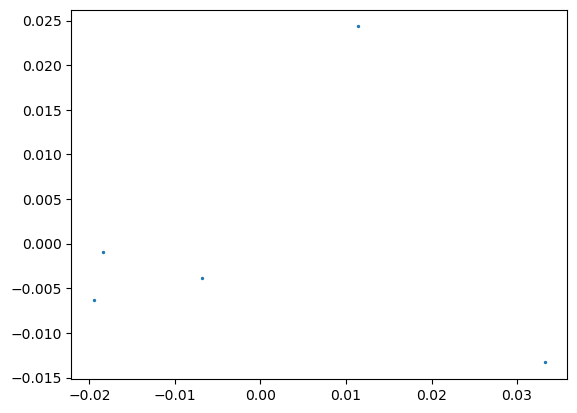

In [22]:
import matplotlib.pyplot as plt

plt.scatter(PCA_X_reduced[:, 0], PCA_X_reduced[:, 1], s=2)